In [1]:
import torch

import triton
import triton.language as tl
import matplotlib
import pandas as pd
import numpy as np


In [2]:
# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `_matmul`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

@triton.jit
def d_leacky_relu(x):
    return tl.where(x >= 0, 1.0, 0.01)


In [3]:
@triton.jit
def silu(x):
    return x * tl.sigmoid(x)

@triton.jit
def d_silu(x):
    sig = tl.sigmoid(x)
    return sig + x * sig * (1 - sig)

@torch.jit.script
def torch_silu_derivative(x):
    sig = torch.sigmoid(x)
    return sig + x * sig * (1 - sig)


In [4]:
@triton.jit
def d_sigmoid(x):
    sig = tl.sigmoid(x)
    return sig * (1 - sig)

@torch.jit.script
def torch_sigmoid_derivative(x):
  sigmoid = torch.sigmoid(x)
  return sigmoid * (1 - sigmoid)


In [5]:
@triton.jit
def _mlp_wide_kernel_bwd_dx(
    pid_h, pid_b,
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    H, B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp_bwd_dx
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # pid_b = pid // H
    # pid_h = pid % H
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)

    x_ptrs = x_ptr + ((pid_h * B + pid_b * BLOCK_SIZE_B + offs_b[:, None]) * stride_xb + offs_d[None, :] * stride_xd)
    x_mask = (offs_b[:, None] < B - pid_b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

    do_ptrs = do_ptr + ((pid_h * B + pid_b * BLOCK_SIZE_B + offs_b[:, None]) * stride_dob + offs_d[None, :] * stride_dod)
    do_mask = (offs_b[:, None] < B - pid_b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

    w1_ptrs = w1_ptr + ((pid_h * D + offs_d[:, None]) * stride_w1d + offs_e[None, :] * stride_w1e)
    w2_ptrs = w2_ptr + ((pid_h * E + offs_e[:, None]) * stride_w2e + offs_d[None, :] * stride_w2d)

    dw1_ptrs = dw1_ptr + ((pid_h * D + offs_d[:, None]) * stride_dw1d + offs_e[None, :] * stride_dw1e)
    dw2_ptrs = dw2_ptr + ((pid_h * E + offs_e[:, None]) * stride_dw2e + offs_d[None, :] * stride_dw2d)

    x = tl.load(x_ptrs, mask=x_mask, other=0.0) # BLOCK_SIZE_B, D
    do = tl.load(do_ptrs, mask=do_mask, other=0.0) # BLOCK_SIZE_B, D
    dx = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)  # BLOCK_SIZE_B, D

    for e in range(0, tl.cdiv(E, BLOCK_SIZE_E)):

        w1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - e * BLOCK_SIZE_E)
        w2_mask = (offs_e[:, None] < E - e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

        w1 = tl.load(w1_ptrs, mask=w1_mask, other=0.0) # D, BLOCK_SIZE_E
        w2 = tl.load(w2_ptrs, mask=w2_mask, other=0.0) # BLOCK_SIZE_E, D

        z = tl.dot(x, w1, out_dtype=tl.float32)                         # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            h = leaky_relu(z).to(TARGET_TYPE)                           # BLOCK_SIZE_B, BLOCK_SIZE_E
        elif ACTIVATION == "silu":
            h = silu(z).to(TARGET_TYPE)
        elif ACTIVATION == "sigmoid":
            h = tl.sigmoid(z).to(TARGET_TYPE)
        else:
            h = z.to(TARGET_TYPE)                                       # BLOCK_SIZE_B, BLOCK_SIZE_E

        dh = tl.dot(do, tl.trans(w2), out_dtype=tl.float32)             # BLOCK_SIZE_B, BLOCK_SIZE_E

        if ACTIVATION == "leaky_relu":
            dz = (dh * d_leacky_relu(z)).to(TARGET_TYPE)   # BLOCK_SIZE_B, BLOCK_SIZE_E
        elif ACTIVATION == "silu":
            dz = (dh * d_silu(z)).to(TARGET_TYPE)
        elif ACTIVATION == "sigmoid":
            dz = (dh * d_sigmoid(z)).to(TARGET_TYPE)
        else:
            dz = dh.to(TARGET_TYPE)

        dx += tl.dot(dz, tl.trans(w1), out_dtype=tl.float32)             # BLOCK_SIZE_B, D

        w1_ptrs += BLOCK_SIZE_E * stride_w1e
        w2_ptrs += BLOCK_SIZE_E * stride_w2e
        dw1_ptrs += BLOCK_SIZE_E * stride_dw1e
        dw2_ptrs += BLOCK_SIZE_E * stride_dw2e

    return dx


In [6]:
@triton.jit
def _mlp_wide_kernel_bwd_dw1w2(
    pid_h, pid_e,
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    H, B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp_bwd_dw1w2
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # pid_b = pid // H
    # pid_h = pid % H
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)

    x_ptrs = x_ptr + ((pid_h * B + offs_b[:, None]) * stride_xb + offs_d[None, :] * stride_xd)

    do_ptrs = do_ptr + ((pid_h * B + offs_b[:, None]) * stride_dob + offs_d[None, :] * stride_dod)
    do_mask = (offs_b[:, None] < B) & (offs_d[None, :] < D)

    w1_ptrs = w1_ptr + ((pid_h * D + offs_d[:, None]) * stride_w1d + (pid_e * BLOCK_SIZE_E + offs_e[None, :]) * stride_w1e)
    w1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - pid_e * BLOCK_SIZE_E)
    w2_ptrs = w2_ptr + ((pid_h * E + pid_e * BLOCK_SIZE_E + offs_e[:, None]) * stride_w2e + offs_d[None, :] * stride_w2d)
    w2_mask = (offs_e[:, None] < E - pid_e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

    w1 = tl.load(w1_ptrs, mask=w1_mask, other=0.0)                      # D, BLOCK_SIZE_E
    w2 = tl.load(w2_ptrs, mask=w2_mask, other=0.0)                      # BLOCK_SIZE_E, D
    do = tl.load(do_ptrs, mask=do_mask, other=0.0)                      # BLOCK_SIZE_B, D

    dw1 = tl.zeros((D, BLOCK_SIZE_E), dtype=tl.float32)                 # D, BLOCK_SIZE_E
    dw2 = tl.zeros((BLOCK_SIZE_E, D), dtype=tl.float32)                 # BLOCK_SIZE_E, D
    for b in range(0, tl.cdiv(B, BLOCK_SIZE_B)):

        x_mask = (offs_b[:, None] < B - b * BLOCK_SIZE_B) & (offs_d[None, :] < D)
        do_mask = (offs_b[:, None] < B - b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

        x = tl.load(x_ptrs, mask=x_mask, other=0.0)                     # BLOCK_SIZE_B, D
        do = tl.load(do_ptrs, mask=do_mask, other=0.0)                  # BLOCK_SIZE_B, D

        z = tl.dot(x, w1, out_dtype=tl.float32)                         # BLOCK_SIZE_B, BLOCK_SIZE_E
        # activation
        if ACTIVATION == "leaky_relu":
            h = leaky_relu(z).to(TARGET_TYPE)                           # BLOCK_SIZE_B, BLOCK_SIZE_E
        elif ACTIVATION == "silu":
            h = silu(z).to(TARGET_TYPE)
        elif ACTIVATION == "sigmoid":
            h = tl.sigmoid(z).to(TARGET_TYPE)
        else:
            h = z.to(TARGET_TYPE)                                       # BLOCK_SIZE_B, BLOCK_SIZE_E

        dh = tl.dot(do, tl.trans(w2), out_dtype=tl.float32)             # BLOCK_SIZE_B, BLOCK_SIZE_E

        dw2 += tl.dot(tl.trans(h), do, out_dtype=tl.float32)            # BLOCK_SIZE_E, D
        # tl.store(dw2_ptrs, dw2, mask=dw2_mask, eviction_policy="evict_last")

        if ACTIVATION == "leaky_relu":
            dz = (dh * d_leacky_relu(z)).to(TARGET_TYPE)   # BLOCK_SIZE_B, BLOCK_SIZE_E
        elif ACTIVATION == "silu":
            dz = (dh * d_silu(z)).to(TARGET_TYPE)
        elif ACTIVATION == "sigmoid":
            dz = (dh * d_sigmoid(z)).to(TARGET_TYPE)
        else:
            dz = dh.to(TARGET_TYPE)

        dw1 += tl.dot(tl.trans(x), dz, out_dtype=tl.float32)             # D, BLOCK_SIZE_E

        x_ptrs += BLOCK_SIZE_B * stride_xb
        do_ptrs += BLOCK_SIZE_B * stride_dob

    return dw1, dw2


In [7]:
@triton.autotune(
    configs=[
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 32}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 16}, num_stages=4, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 16, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 32}, num_stages=3, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 32}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 32, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 64}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 64, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 64, 'BLOCK_SIZE_E': 128, 'GROUP_SIZE_B': 1}, num_stages=2, num_warps=4),
        # triton.Config({'BLOCK_SIZE_B': 128, 'BLOCK_SIZE_E': 128}, num_stages=2, num_warps=4),
    ],
    key=['H', 'B', 'D', 'E'],
)
@triton.jit
def mlp_wide_kernel_bwd2(
    x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
    H, B, D: tl.constexpr, E,
    stride_xb, stride_xd,
    stride_w1d, stride_w1e,
    stride_w2e, stride_w2d,
    stride_ob, stride_od,
    stride_dxb, stride_dxd,
    stride_dw1d, stride_dw1e,
    stride_dw2e, stride_dw2d,
    stride_dob, stride_dod,
    BLOCK_SIZE_B: tl.constexpr, BLOCK_SIZE_E: tl.constexpr,
    ACTIVATION: tl.constexpr
):
    """Kernel for computing the mlp
    Z = X @ W1, H = f(Z), O = H @ W2
    - X has shape (B, D)
    - W1 has shape (D, E)
    - W2 has shape (E, D)
    - O has shape (B, D)
    - dX has shape (B, D)
    - dW1 has shape (D, E)
    - dW2 has shape (E, D)
    - dO has shape (B, D)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    pid = tl.program_id(axis=0)
    pid_x_w = 0

    # batch_groups = tl.cdiv(B, BLOCK_SIZE_B)
    batch_groups_e = tl.cdiv(E, BLOCK_SIZE_E)
    batch_groups_b = tl.cdiv(B, BLOCK_SIZE_B)
    idx = pid % (batch_groups_e + batch_groups_b)
    pid_h = pid // (batch_groups_e + batch_groups_b)
    # pid_b = pid // H
    # pid_h = pid % H
    TARGET_TYPE = x_ptr.type.element_ty

    offs_b = tl.arange(0, BLOCK_SIZE_B)
    offs_d = tl.arange(0, D)
    offs_e = tl.arange(0, BLOCK_SIZE_E)

    if idx >= batch_groups_e:

        pid_b = idx - batch_groups_e

        dx_ptrs = dx_ptr + ((pid_h * B + pid_b * BLOCK_SIZE_B + offs_b[:, None]) * stride_dxb + offs_d[None, :] * stride_dxd)
        dx_mask = (offs_b[:, None] < B - pid_b * BLOCK_SIZE_B) & (offs_d[None, :] < D)

        dx = tl.zeros((BLOCK_SIZE_B, D), dtype=tl.float32)  # BLOCK_SIZE_B, D
        dx = _mlp_wide_kernel_bwd_dx(
            pid_h, pid_b,
            x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
            H, B, D, E,
            stride_xb, stride_xd,
            stride_w1d, stride_w1e,
            stride_w2e, stride_w2d,
            stride_ob, stride_od,
            stride_dxb, stride_dxd,
            stride_dw1d, stride_dw1e,
            stride_dw2e, stride_dw2d,
            stride_dob, stride_dod,
            BLOCK_SIZE_B, BLOCK_SIZE_E,
            ACTIVATION
        )

        tl.store(dx_ptrs, dx.to(TARGET_TYPE), mask=dx_mask)

    else:

        pid_e = idx

        dw1_ptrs = dw1_ptr + ((pid_h * D + offs_d[:, None]) * stride_dw1d + (pid_e * BLOCK_SIZE_E + offs_e[None, :]) * stride_dw1e)
        dw1_mask = (offs_d[:, None] < D) & (offs_e[None, :] < E - pid_e * BLOCK_SIZE_E)
        dw2_ptrs = dw2_ptr + ((pid_h * E + pid_e * BLOCK_SIZE_E + offs_e[:, None]) * stride_dw2e + offs_d[None, :] * stride_dw2d)
        dw2_mask = (offs_e[:, None] < E - pid_e * BLOCK_SIZE_E) & (offs_d[None, :] < D)

        dw1, dw2 = _mlp_wide_kernel_bwd_dw1w2(
            pid_h, pid_e,
            x_ptr, w1_ptr, w2_ptr, o_ptr, dx_ptr, dw1_ptr, dw2_ptr, do_ptr,
            H, B, D, E,
            stride_xb, stride_xd,
            stride_w1d, stride_w1e,
            stride_w2e, stride_w2d,
            stride_ob, stride_od,
            stride_dxb, stride_dxd,
            stride_dw1d, stride_dw1e,
            stride_dw2e, stride_dw2d,
            stride_dob, stride_dod,
            BLOCK_SIZE_B, BLOCK_SIZE_E,
            ACTIVATION
        )

        tl.store(dw1_ptrs, dw1.to(TARGET_TYPE), mask=dw1_mask)
        tl.store(dw2_ptrs, dw2.to(TARGET_TYPE), mask=dw2_mask)


In [8]:
def mlp_wide_triton_bwd2(x, w1, w2, o, do, activation=""):
    # Check constraints.
    assert x.shape[-1] == w1.shape[-2], "Incompatible dimensions"
    assert w1.shape[-1] == w2.shape[-2], "Incompatible dimensions"
    assert x.shape[-1] == w2.shape[-1], "Incompatible dimensions"
    assert x.shape == o.shape, "Incompatible dimensions"
    assert x.shape == do.shape, "Incompatible dimensions"

    H, B, D = x.shape
    E = w1.shape[-1]

    x = x.view(H * B, D)
    w1 = w1.view(D * H, E)
    w2 = w2.view(E * H, D)
    o = o.view(H * B, D)
    do = do.view(H * B, D)

    assert x.is_contiguous(), "Matrix X must be contiguous"
    assert w1.is_contiguous(), "Matrix W1 must be contiguous"
    assert w2.is_contiguous(), "Matrix W2 must be contiguous"
    assert o.is_contiguous(), "Matrix O must be contiguous"
    assert do.is_contiguous(), "Matrix dO must be contiguous"


    # Allocates output.
    dx = torch.zeros_like(x)
    dw1 = torch.zeros_like(w1)
    dw2 = torch.zeros_like(w2)
    # print(dx.shape, dw1.shape, dw2.shape, do.shape)

    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
        # triton.cdiv(B, META['BLOCK_SIZE_B']) * H,
        (triton.cdiv(B, META['BLOCK_SIZE_B']) + triton.cdiv(E, META['BLOCK_SIZE_E'])) * H,
    )
    mlp_wide_kernel_bwd2[grid](
        x, w1, w2, o, dx, dw1, dw2, do,
        H, B, D, E,
        x.stride(0), x.stride(1),
        w1.stride(0), w1.stride(1),
        w2.stride(0), w2.stride(1),
        o.stride(0), o.stride(1),
        dx.stride(0), dx.stride(1),
        dw1.stride(0), dw1.stride(1),
        dw2.stride(0), dw2.stride(1),
        do.stride(0), do.stride(1),
        ACTIVATION=activation
    )

    # print(dx.shape, dw1.shape, dw2.shape)
    return dx.view(H, B, D), dw1.view(H, D, E), dw2.view(H, E, D)


In [9]:
def mlp_torch_bwd_raw(x, w1, w2, o, do, activation=""):
    # x: H, B, D
    # w1: H, D, E
    # w2: H, E, D
    # o: H, B, D
    # do: H, B, D
    z = torch.bmm(x, w1) # H, B, E
    if activation == "leaky_relu":
        h = torch.nn.functional.leaky_relu(z, negative_slope=0.01)
    elif activation == "silu":
        h = torch.nn.functional.silu(z)
    elif activation == "sigmoid":
        h = torch.nn.functional.sigmoid(z)
    else:
        h = z

    dh = torch.bmm(do, torch.transpose(w2, -1, -2)) # H, B, E
    dw2 = torch.bmm(torch.transpose(h, -1, -2), do) # H, E, D

    if activation == "leaky_relu":
        dz = dh * torch.where(z >= 0, 1.0, 0.01).to(dh.dtype)  # H, B, E
    elif activation == "silu":
        dz = dh * torch_silu_derivative(z)
    elif activation == "sigmoid":
        dz = dh * torch_sigmoid_derivative(z)
    else:
        dz = dh

    dx = torch.bmm(dz, torch.transpose(w1, -1, -2)) # H, B, D
    dw1 = torch.bmm(torch.transpose(x, -1, -2), dz) # H, D, E

    return dx, dw1, dw2


In [10]:
def mlp_torch_bwd2(x, w1, w2, o, do, activation=""):
    if activation == "leaky_relu":
        y_ref = torch.nn.functional.leaky_relu(x @ w1, negative_slope=0.01) @ w2
    elif activation == "silu":
        y_ref = torch.nn.functional.silu(x @ w1) @ w2
    elif activation == "sigmoid":
        y_ref = torch.nn.functional.sigmoid(x @ w1) @ w2
    else:
        y_ref = x @ w1 @ w2
    y_ref.backward(do, retain_graph=True)
    # print(x.grad.shape, w1.grad.shape, w2.grad.shape)
    return x.grad, w1.grad, w2.grad

In [11]:
def unit_test_bwd2():
    torch.manual_seed(12932)
    DTYPE = torch.bfloat16
    B = 1024 * 4
    D = 64
    E = 768
    H = E // D

    x = torch.randn((H, B, D), device='cuda', dtype=DTYPE, requires_grad=True)
    w1 = torch.randn((H, D, E), device='cuda', dtype=DTYPE, requires_grad=True)
    w2 = torch.randn((H, E, D), device='cuda', dtype=DTYPE, requires_grad=True)
    o = torch.randn((H, B, D), device='cuda', dtype=DTYPE)
    do = 0.05 * torch.randn((H, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)

    activation = "silu"

    triton_output = mlp_wide_triton_bwd2(x, w1, w2, o, do, activation=activation)
    # triton_output = mlp_torch_bwd_raw(x, w1, w2, o, do, activation=activation)
    torch_output = mlp_torch_bwd2(x, w1, w2, o, do, activation=activation)

    print(f"triton_output={triton_output[1].shape, triton_output[1]}")
    print(f"torch_output={torch_output[1].shape, torch_output[1]}")

    eplison = 3e-2
    if torch.allclose(triton_output[1], torch_output[1], atol=eplison, rtol=eplison):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

    dx_diff = np.abs(triton_output[0].to(torch.float32).detach().cpu().numpy() - torch_output[0].to(torch.float32).detach().cpu().numpy())
    dx_rel_diff = dx_diff / np.abs(triton_output[0].to(torch.float32).detach().cpu().numpy() + torch_output[0].to(torch.float32).detach().cpu().numpy() + eplison)
    print(f"[dx: {triton_output[0].shape}, {torch_output[0].shape}] max diff: {np.max(dx_diff):.2e}, mean diff: {np.mean(dx_diff):.2e}, rel max diff: {np.max(dx_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dx_rel_diff)*100:.2f}%")

    dw1_diff = np.abs(triton_output[1].to(torch.float32).detach().cpu().numpy() - torch_output[1].to(torch.float32).detach().cpu().numpy())
    dw1_rel_diff = dw1_diff / np.abs(triton_output[1].to(torch.float32).detach().cpu().numpy() + torch_output[1].to(torch.float32).detach().cpu().numpy() + eplison)
    print(f"[dw1: {triton_output[1].shape}, {torch_output[1].shape}] max diff: {np.max(dw1_diff):.2e}, mean diff: {np.mean(dw1_diff):.2e}, rel max diff: {np.max(dw1_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dw1_rel_diff)*100:.2f}%")

    dw2_diff = np.abs(triton_output[2].to(torch.float32).detach().cpu().numpy() - torch_output[2].to(torch.float32).detach().cpu().numpy())
    dw2_rel_diff = dw2_diff / np.abs(triton_output[2].to(torch.float32).detach().cpu().numpy() + torch_output[2].to(torch.float32).detach().cpu().numpy() + eplison)
    print(f"[dw2: {triton_output[2].shape}, {torch_output[2].shape}] max diff: {np.max(dw2_diff):.2e}, mean diff: {np.mean(dw2_diff):.2e}, rel max diff: {np.max(dw2_rel_diff)*100:.2f}%, rel mean diff: {np.mean(dw2_rel_diff)*100:.2f}%")

unit_test_bwd2()


triton_output=(torch.Size([12, 64, 768]), tensor([[[-6.1250e+00, -7.4707e-02,  3.7500e+00,  ..., -2.4844e+00,
          -2.5938e+00,  1.5938e+00],
         [-2.9883e-01,  1.2344e+00, -5.9375e-01,  ..., -1.7969e+00,
           7.1875e-01, -3.6914e-01],
         [-3.9062e+00,  1.3438e+00,  1.8438e+00,  ..., -2.0156e+00,
           1.7578e+00, -3.7695e-01],
         ...,
         [ 1.5469e+00,  1.8672e+00,  4.1875e+00,  ..., -1.3594e+00,
           3.7031e+00, -2.1719e+00],
         [-6.2109e-01, -2.3125e+00, -1.0234e+00,  ...,  2.1719e+00,
          -3.6719e+00,  2.1973e-01],
         [-5.1875e+00, -3.5469e+00, -3.9062e+00,  ..., -6.8359e-01,
           4.1875e+00,  2.3906e+00]],

        [[-1.7422e+00,  3.5625e+00, -2.5625e+00,  ..., -1.4531e+00,
           1.2812e+00,  2.1094e+00],
         [ 4.8242e-01,  1.9609e+00, -4.0625e-01,  ...,  1.5703e+00,
          -2.3438e-01,  6.3281e-01],
         [-2.0781e+00, -1.9844e+00, -7.2266e-01,  ...,  7.9688e-01,
          -1.9141e+00,  6.3281e-01

/home/centos/miniconda3/envs/torch20/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [24]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['E'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            128 * i for i in range(2, 20)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-32', 'triton-32', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-32", "Triton-32", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-.'), ('blue', '-.'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_bwd2(E, provider):
    DTYPE = torch.bfloat16
    D = int(provider[provider.find('-') + 1:])
    HEAD = 768 // D
    B = 1024 * 4

    x = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE, requires_grad=True)
    w1 = torch.randn((HEAD, D, E), device='cuda', dtype=DTYPE, requires_grad=True)
    w2 = torch.randn((HEAD, E, D), device='cuda', dtype=DTYPE, requires_grad=True)
    o = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    do = 0.1 * torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)

    activation = "silu"

    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_bwd2(x, w1, w2, o, do, activation=activation), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_bwd2(x, w1, w2, o, do, activation=activation), quantiles=quantiles)
    perf = lambda ms: 8 * B * D * E * HEAD * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


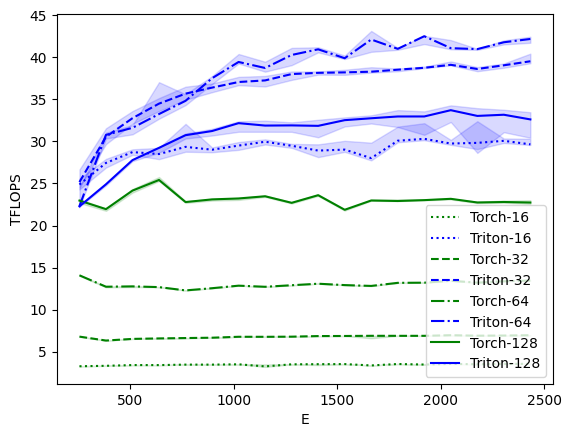

mlp-performance:
         E  Torch-16  Triton-16  Torch-32  Triton-32   Torch-64  Triton-64  Torch-128  Triton-128
0    256.0  3.264950  24.872021  6.786900  25.165823  14.074846  22.308892  22.961519   22.278034
1    384.0  3.315947  27.441152  6.320623  30.541049  12.721524  30.772902  21.946940   24.900221
2    512.0  3.405490  28.728110  6.516425  32.762665  12.761573  31.615356  24.151462   27.776849
3    640.0  3.401523  28.493912  6.572770  34.492631  12.674166  33.252939  25.413608   29.235389
4    768.0  3.458111  29.353605  6.617941  35.679334  12.282252  34.823558  22.789109   30.740012
5    896.0  3.456844  29.011984  6.657909  36.396852  12.543490  37.512941  23.106082   31.234178
6   1024.0  3.494525  29.502725  6.768646  37.063070  12.846773  39.444864  23.215705   32.171075
7   1152.0  3.248158  29.959315  6.765007  37.252041  12.712866  38.729894  23.477407   31.882378
8   1280.0  3.493507  29.481988  6.781047  38.007663  12.897614  40.278207  22.696451   31.903933
9  

In [25]:
benchmark_bwd2.run(show_plots=True, print_data=True)


In [14]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['HEAD'],  # Argument names to use as an x-axis for the plot
        x_vals=[
            # 2 ** i for i in range(5, 12)
            i * 2 for i in range(2, 24)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch-16', 'triton-16', 'torch-32', 'triton-32', 'torch-64', 'triton-64', 'torch-128', 'triton-128'],
        # Label name for the lines
        line_names=["Torch-16", "Triton-16", "Torch-32", "Triton-32", "Torch-64", "Triton-64", "Torch-128", "Triton-128"],
        # Line styles
        styles=[('green', ':'), ('blue', ':'), ('green', '--'), ('blue', '--'), ('green', '-.'), ('blue', '-.'), ('green', '-'), ('blue', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark_bwd3(HEAD, provider):
    DTYPE = torch.bfloat16
    D = int(provider[provider.find('-') + 1:])
    E = 768 * 4 // HEAD
    # HEAD = 384 // D
    B = 1024 * 4

    x = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE, requires_grad=True)
    w1 = torch.randn((HEAD, D, E), device='cuda', dtype=DTYPE, requires_grad=True)
    w2 = torch.randn((HEAD, E, D), device='cuda', dtype=DTYPE, requires_grad=True)
    o = torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)
    do = 0.1 * torch.randn((HEAD, B, D), device='cuda', dtype=DTYPE) / np.sqrt(D)

    activation = "silu"

    quantiles = [0.5, 0.2, 0.8]
    if provider.startswith('torch'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_torch_bwd2(x, w1, w2, o, do, activation=activation), quantiles=quantiles)
    if provider.startswith('triton'):
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: mlp_wide_triton_bwd2(x, w1, w2, o, do, activation=activation), quantiles=quantiles)
    perf = lambda ms: 8 * B * D * E * HEAD * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


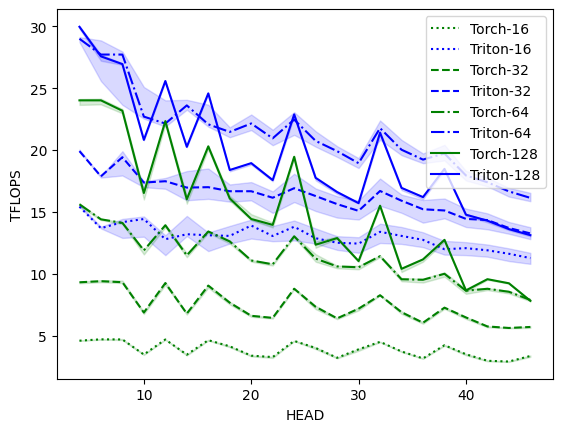

mlp-performance:
    HEAD  Torch-16  Triton-16  Torch-32  Triton-32   Torch-64  Triton-64  Torch-128  Triton-128
0    4.0  4.585609  15.420236  9.306887  19.909671  15.611553  28.992886  24.013192   29.959315
1    6.0  4.695117  13.677078  9.396369  17.873454  14.396924  27.715666  24.013192   27.568600
2    8.0  4.685937  14.169946  9.312915  19.418074  14.107392  27.715666  23.172950   26.944137
3   10.0  3.467334  14.420550  6.862993  17.368398  11.885368  22.698049  16.523943   20.819073
4   12.0  4.681143  12.787512  9.243220  17.476266  13.919150  22.138398  22.335499   25.575023
5   14.0  3.457692  13.191530  6.775700  16.962128  11.479284  23.605896  16.018286   20.255380
6   16.0  4.626071  13.107200  9.039448  16.995322  13.414619  22.075285  20.295019   24.576000
7   18.0  4.129910  13.056000  7.658882  16.667234  12.609416  21.461917  16.087938   18.383843
8   20.0  3.376552  13.893595  6.596716  16.667234  11.072226  22.144452  14.423199   18.937642
9   22.0  3.261867  13.

In [15]:
benchmark_bwd3.run(show_plots=True, print_data=True)
